## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [2]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip setuptools

In [4]:
!pip3 install --trusted-host pypi.org --trusted-host files.pythonhosted.org imblearn

In [68]:
!pip freeze

altair==1.2.1
asn1crypto==0.22.0
atari-py==0.1.7
atomicwrites==1.3.0
attrs==19.1.0
audioread==2.1.6
av==0.3.3
awscli==1.16.17
backcall==0.1.0
backports.functools-lru-cache==1.4
backports.weakref==1.0rc1
beautifulsoup4==4.6.0
bleach==1.5.0
blinker==1.4
bokeh==0.12.13
boto==2.48.0
boto3==1.9.7
botocore==1.12.7
Box2D==2.3.2
Box2D-kengz==2.3.3
bresenham==0.2
bz2file==0.98
cassandra-driver==3.11.0
certifi==2019.11.28
cffi==1.11.2
chardet==3.0.4
click==6.7
cloudpickle==0.2.2
colorama==0.3.9
colour==0.1.5
conda==4.6.14
cryptography==2.1.4
cycler==0.10.0
Cython==0.29.7
cytoolz==0.9.0.1
dask==0.16.1
decorator==4.0.11
defusedxml==0.5.0
dill==0.2.7.1
docutils==0.14
dronekit==2.9.2
entrypoints==0.2.3
et-xmlfile==1.0.1
eventlet==0.22.0
fastcache==1.0.2
Flask==0.12.2
Flask-SocketIO==2.9.2
future==0.16.0
gensim==3.4.0
glfw==1.8.0
greenlet==0.4.12
gym==0.9.6
h5py==2.7.1
heapdict==1.0.0
html2text==2018.1.9
html5lib==0.9999999
idna==2.6
imageio==2.1.2
imbalanced-learn==0.7.0
ipykernel==4.9.0
ipython==6.

In [6]:
!pip install -U numpy

Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (1.19.4)


!pip install -U imbalanced-learn

In [44]:
!pip freeze > requirements.txt

## Load packages

### standard packages

In [5]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### ML packages

In [6]:
import scipy as sp
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

### Misc. Packages

In [7]:
# imbalance
# from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import SVMSMOTE


## Load Data

In [8]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [9]:
test_data = pd.read_csv('./Test.csv')

In [10]:
test_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000
mean,63339.155774,0.011525,1.493469,29.986774,-0.000387,1.680792,2.319256,2.505642,1.704010
std,36441.521173,0.106734,0.864138,4.981025,0.999026,0.466175,0.845162,1.119879,0.456492
min,2.000000,0.000000,0.000000,9.202546,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31688.500000,0.000000,1.000000,26.606134,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,63601.000000,0.000000,1.000000,29.979507,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,95017.250000,0.000000,2.000000,33.369989,0.826206,2.000000,3.000000,4.000000,2.000000
max,126178.000000,1.000000,3.000000,55.107509,1.691984,2.000000,4.000000,4.000000,2.000000


In [11]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


## Parse and Inspect Data

In [12]:
features = train_data.columns[3:]

In [13]:
train_data.Promotion = train_data.Promotion.replace(['Yes', 'No'], [1,0])

In [14]:
test_data.Promotion = test_data.Promotion.replace(['Yes', 'No'], [1,0])

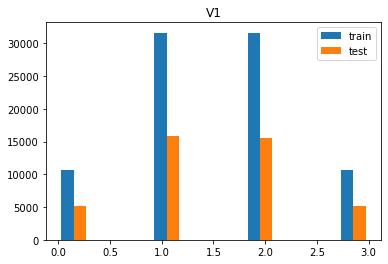

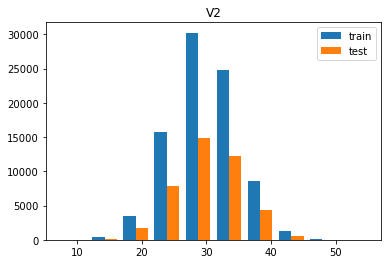

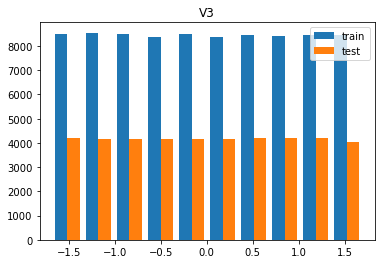

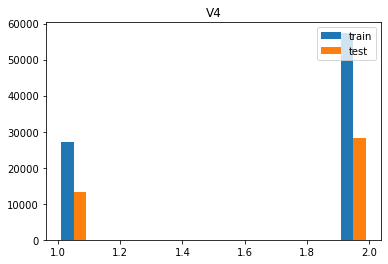

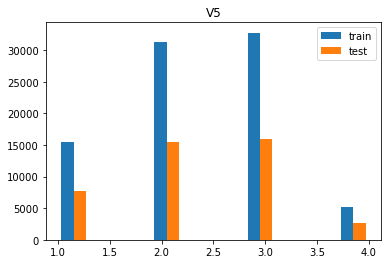

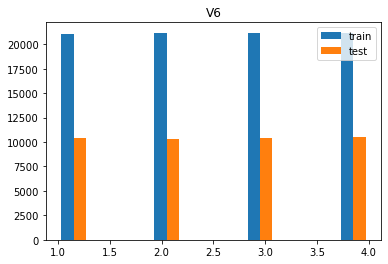

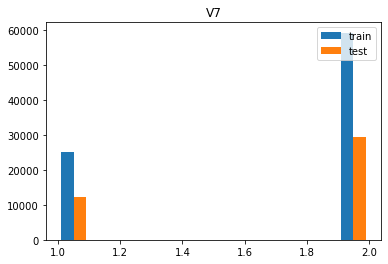

In [15]:
for f in features:
    plt.hist([train_data[f], test_data[f]], label=['train', 'test'])
    plt.title(f)
    plt.legend(loc='upper right')
    plt.show()

In [16]:
promo_train_data = train_data.loc[train_data['Promotion']==1]

In [17]:
no_promo_data = train_data.loc[train_data.Promotion==0]

In [18]:
promo_train_data.describe()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
count,42364.000000,42364.0,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000,42364.000000
mean,62847.675385,1.0,0.017019,1.505028,29.970338,0.007446,1.678949,2.324662,2.504225,1.701185
std,36299.420024,0.0,0.129344,0.868226,5.024443,0.998020,0.466886,0.840242,1.117279,0.457744
min,8.000000,1.0,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31387.500000,1.0,0.000000,1.000000,26.571116,-0.818772,1.000000,2.000000,2.000000,1.000000
50%,62717.000000,1.0,0.000000,2.000000,29.989227,0.047006,2.000000,2.000000,3.000000,2.000000
75%,93960.500000,1.0,0.000000,2.000000,33.332278,0.826206,2.000000,3.000000,4.000000,2.000000
max,126181.000000,1.0,1.000000,3.000000,49.823708,1.691984,2.000000,4.000000,4.000000,2.000000


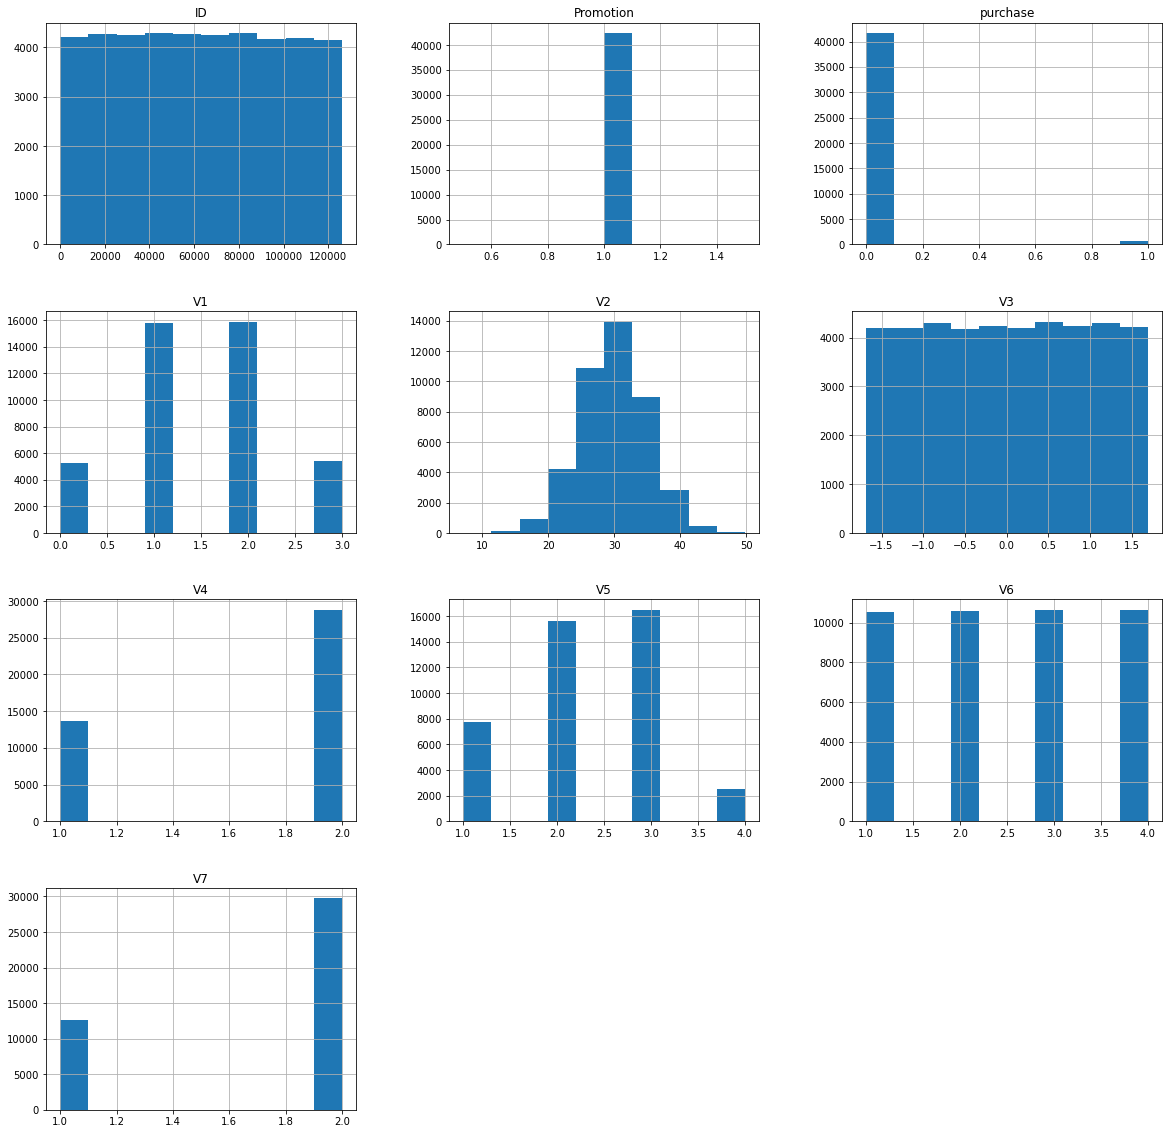

In [19]:
promo_train_data.hist(figsize=(20,20));

In [20]:
promo_purch_df = promo_train_data.loc[promo_train_data['purchase']==1]

In [21]:
no_promo_purch = no_promo_data.loc[no_promo_data['purchase']==1]

In [22]:
promo_purch_corr = promo_purch_df.corr()

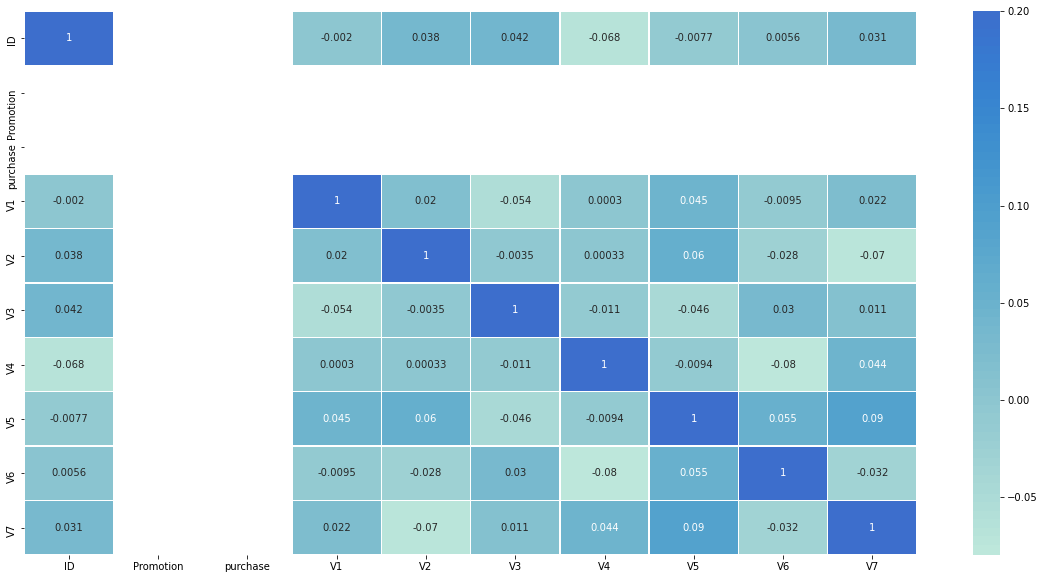

In [23]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(promo_purch_corr, center=.5, annot=True, vmax=.2, linewidths=.5, ax=ax);

In [24]:
no_promo_purch_corr = no_promo_purch.corr()

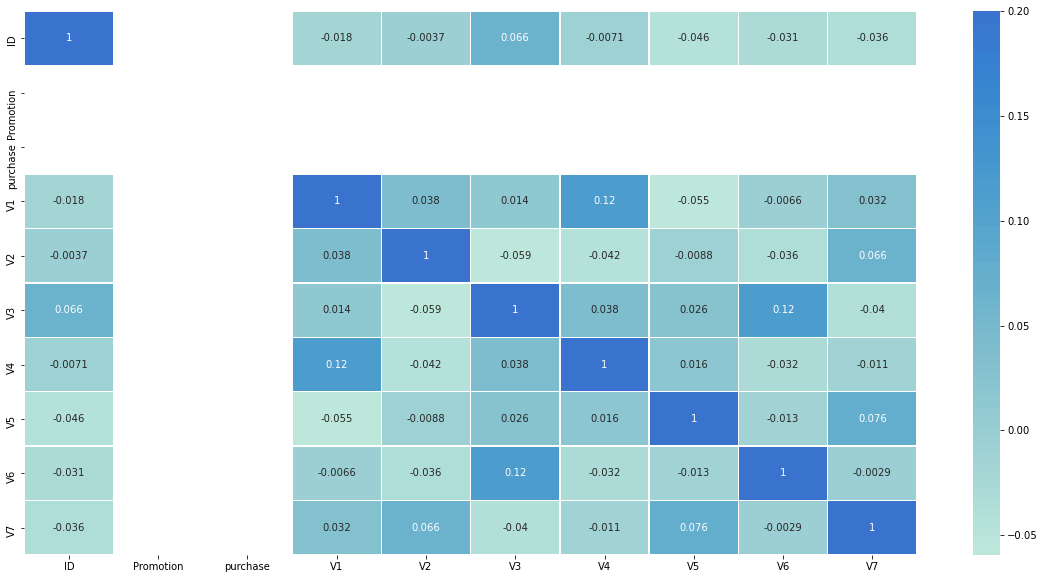

In [25]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(no_promo_purch_corr, center=.5, annot=True, vmax=.2, linewidths=.5, ax=ax);

In [26]:
purch_trt = promo_train_data.purchase.value_counts()[1]
cust_trt = promo_train_data.purchase.count()

In [27]:
purch_ctr = no_promo_data.purchase.value_counts()[1]
cust_ctr = no_promo_data.purchase.count()

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [28]:
irr = (purch_trt / cust_trt) - (purch_ctr / cust_ctr)

In [29]:
irr

0.009454547819772702

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [30]:
nir = (10 * purch_trt - .15 * cust_trt) - 10 * purch_ctr

In [31]:
nir

-2334.5999999999995

In [32]:
promo_corr = promo_train_data.corr()

<AxesSubplot:>

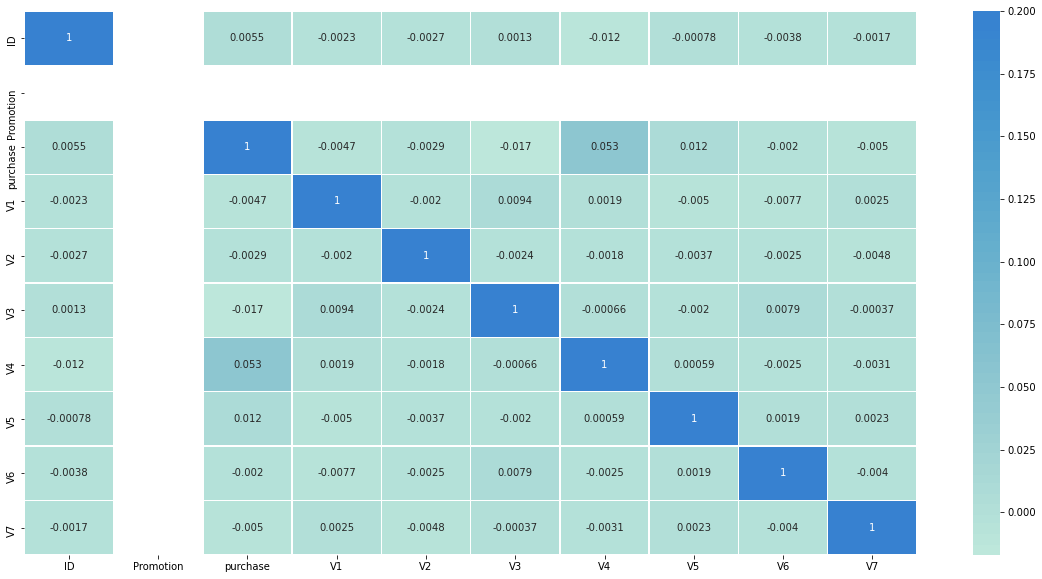

In [33]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(promo_corr, center=.5, annot=True, vmax=.2, linewidths=.5, ax=ax)

<AxesSubplot:>

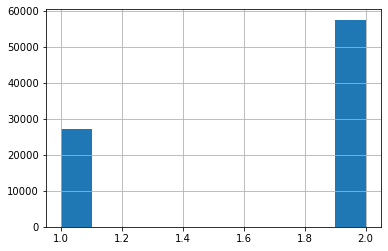

In [34]:
train_data.V4.hist()

<AxesSubplot:>

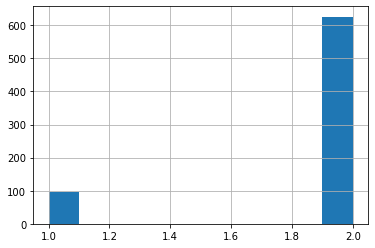

In [35]:
promo_purch_df.V4.hist()

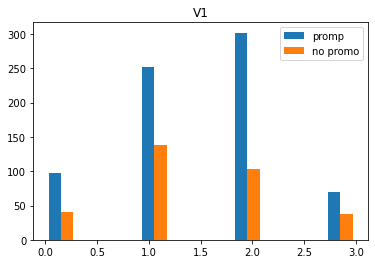

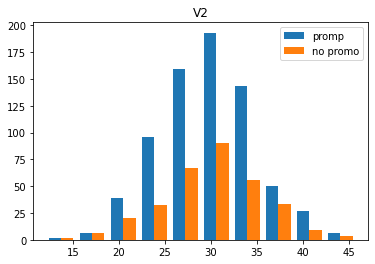

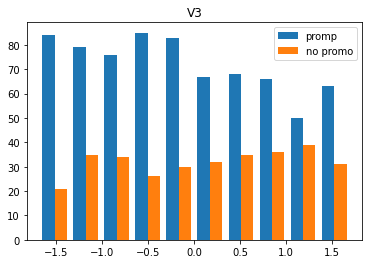

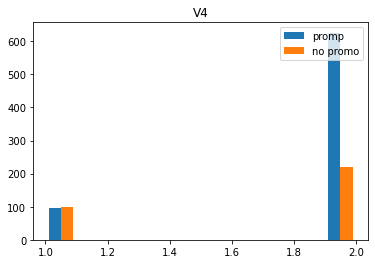

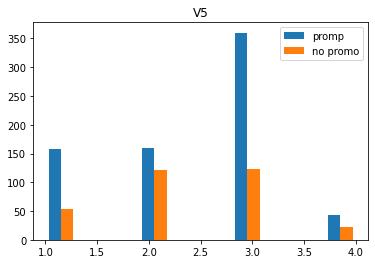

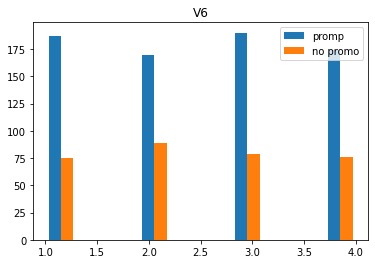

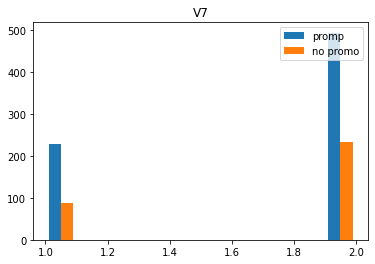

In [36]:
for f in features:
    plt.hist([promo_purch_df[f], no_promo_purch[f]], label=['promp', 'no promo'])
    plt.title(f)
    plt.legend(loc='upper right')
    plt.show()

## Build strategy

In [37]:
# V1 >=1 & <=2
# V2 >=25 & <=35
# V4 > 1
# V5 >=2 & <=3
# V7 > 1
v1 = (train_data['V1']>=1) & (train_data['V1']<=2)
v2 = (train_data['V2']>=25) & (train_data['V2']<=35)
v3 = (train_data['V3']>=-1.5) & (train_data['V3']<=1.5)
v4 = (train_data['V4']>1)
v5 = (train_data['V5']>=2) & (train_data['V5']<=4)
v6 = (train_data['V6']>=1) & (train_data['V6']<=4)
v7 = (train_data['V7']>1)
tdf = pd.concat([v1, v2, v3, v4, v5, v6, v7], axis=1)
tdf

,V1,V2,V3,V4,V5,V6,V7
0,True,True,True,False,False,True,True
1,False,True,True,True,True,True,True
2,True,True,True,False,False,True,True
3,False,True,True,True,False,True,True
4,False,True,True,False,False,True,True
...,...,...,...,...,...,...,...
84529,True,True,True,False,False,True,False
84530,False,True,True,False,False,True,False
84531,True,True,True,True,True,True,True
84532,True,False,True,True,True,True,True


In [38]:
strategy = ((train_data['V1']>=1) & (train_data['V1']<=2)
& (train_data['V2']>=29) & (train_data['V2']<=31)
& (train_data['V3']>=-1.5) & (train_data['V3']<=1.5)
& (train_data['V4']>1)
& (train_data['V5']>=2) & (train_data['V5']<=4)
& (train_data['V6']>=1) & (train_data['V6']<=4)
& (train_data['V7']>1))

In [39]:
strategy = strategy.replace([True, False], ['Yes', 'No'])

In [40]:
len(strategy)

84534

In [41]:
tdf = tdf.replace([True, False], ['Yes', 'No'])

In [42]:
len(np.array(tdf))

84534

In [46]:
test = test_data
    
promotion = []
    
num_test_points = test.shape[0]
    
for i in range(num_test_points):
    promotion.append('Yes')
        
promotion = np.array(promotion)
promotion

array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

In [47]:
len(promotion)

41650

## Test 1

In [54]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promo = []
    strategy = ((df['V1']>=1) & (df['V1']<=2)
& (df['V2']>=27) & (df['V2']<=33)
& (df['V3']>=0) & (df['V3']<=1)
& (df['V4']>1)
& (df['V5']>=3) & (df['V5']<=3.5)
& (df['V6']>=2) & (df['V6']<=3)
& (df['V7']>1))
    
    strategy = strategy.replace([True, False], ['Yes', 'No'])
    
    promotion = np.array(strategy)
    
    return promotion

In [78]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

IndexError: positional indexers are out-of-bounds




## Model Testing




In [47]:
dummy_df = pd.get_dummies(train_data, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
dummy_df.columns

Index(['ID', 'Promotion', 'purchase', 'V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
       'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2', 'V5_3', 'V5_4', 'V6_1', 'V6_2',
       'V6_3', 'V6_4', 'V7_1', 'V7_2'],
      dtype='object')

In [56]:
from sklearn.preprocessing import StandardScaler

In [57]:
scaler = StandardScaler()

In [129]:
train_data.shape

(84534, 10)

In [130]:
dummy_df.shape

(84534, 21)

In [58]:
svms = SVMSMOTE(random_state=42)

In [151]:
train_data.columns

Index(['ID', 'Promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7'],
      dtype='object')

In [59]:
X = train_data.iloc[:,3:]
y = train_data['purchase']

In [55]:
X.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'], dtype='object')

In [60]:
X, y = svms.fit_resample(X,y)

In [57]:
y.value_counts()

0    83494
1    46385
Name: purchase, dtype: int64

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [159]:
promotion_yes_no = []
for value in lr_y_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

In [63]:
# logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
confusion_matrix(y_test, lr_y_pred)

array([[14732,  2082],
       [ 7271,  1891]], dtype=int64)

In [64]:
promotion_yes_no = []
for value in lr_y_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

In [65]:
print(accuracy_score(y_test, lr_y_pred))
print(f1_score(y_test, lr_y_pred))
print(recall_score(y_test, lr_y_pred))

0.6399368647982754
0.2879330034259612
0.20639598340973586


In [66]:
rand_mod = RandomForestClassifier()
rand_mod.fit(X_train, y_train)
rand_y_pred = rand_mod.predict(X_test)
confusion_matrix(y_test, rand_y_pred)

array([[16646,   168],
       [  200,  8962]], dtype=int64)

In [67]:
promotion_yes_no = []
for value in rand_y_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype='<U3')

In [68]:
print(accuracy_score(y_test, rand_y_pred))
print(f1_score(y_test, rand_y_pred))
print(recall_score(y_test, rand_y_pred))

0.9858330766861718
0.9798819155915154
0.9781707050862257


In [69]:
clf = GradientBoostingClassifier()

gbc = clf.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)

In [70]:
confusion_matrix(y_test, gbc_pred)

array([[15745,  1069],
       [ 2970,  6192]], dtype=int64)

In [71]:
promotion_yes_no = []
for value in gbc_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'Yes', 'No', 'Yes'], dtype='<U3')

In [72]:
print(accuracy_score(y_test, gbc_pred))
print(f1_score(y_test, gbc_pred))
print(recall_score(y_test, gbc_pred))

0.8445103172158915
0.7540644218474091
0.6758349705304518


In [73]:
from imblearn.ensemble import BalancedRandomForestClassifier  

In [74]:
blrf = BalancedRandomForestClassifier()
blrf.fit(X_train, y_train)
blrf_y_pred = blrf.predict(X_test)
confusion_matrix(y_test, blrf_y_pred)

array([[16583,   231],
       [  175,  8987]], dtype=int64)

In [75]:
promotion_yes_no = []
for value in blrf_y_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype='<U3')

In [76]:
print(accuracy_score(y_test, blrf_y_pred))
print(f1_score(y_test, blrf_y_pred))
print(recall_score(y_test, blrf_y_pred))

0.9843701878657222
0.97791077257889
0.9808993669504475


## Pipeline Build

### THIS TAKES CONSIDERABLE TIME

In [95]:
pipeline = Pipeline([
    ('clf_r', RandomForestClassifier())
])

    
parameters = [{
    'clf_r': [RandomForestClassifier()],
    'clf_r__max_features': ['auto','sqrt']
    },
    {
        'clf_r': [BalancedRandomForestClassifier()],
        'clf_r__sampling_strategy': ['auto', 'all'],
        'clf_r__class_weight': ['balanced', 'balanced_subsample']
    }
        ]
    
model = GridSearchCV(pipeline, param_grid=parameters, verbose=3, cv=3)

In [ ]:
pipeline = Pipeline([
    ('clf_r', BalancedRandomForestClassifier())
])

    
parameters = {
        'clf_r__sampling_strategy': ['auto', 'all'],
        'clf_r__class_weight': ['balanced', 'balanced_subsample']
    }
        
    
model2 = GridSearchCV(pipeline, param_grid=parameters, verbose=3, cv=5)

In [96]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=2 
[CV]  clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=2, score=0.950, total=   4.8s
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=2 


[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV]  clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=2, score=0.947, total=   4.8s
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=2 


[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV]  clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=2, score=0.950, total=   4.7s
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=3 
[CV]  clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=3, score=0.950, total=   4.7s
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=3 
[CV]  clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=3, score=0.947, total=   4.7s
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=3 
[CV]  clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=3, score=0.950, total=   4.7s
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=4 
[CV]  clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=4, score=0.950, total=   4.8s
[CV] clf_r__max_features=auto, clf_r__min_samples_leaf=1, clf_r__min_samples_split=4 


[CV]  clf_r__max_features=sqrt, clf_r__min_samples_leaf=2, clf_r__min_samples_split=4, score=0.947, total=   4.5s
[CV] clf_r__max_features=sqrt, clf_r__min_samples_leaf=2, clf_r__min_samples_split=4 
[CV]  clf_r__max_features=sqrt, clf_r__min_samples_leaf=2, clf_r__min_samples_split=4, score=0.950, total=   4.6s
[CV] clf_r__max_features=sqrt, clf_r__min_samples_leaf=4, clf_r__min_samples_split=2 
[CV]  clf_r__max_features=sqrt, clf_r__min_samples_leaf=4, clf_r__min_samples_split=2, score=0.950, total=   4.5s
[CV] clf_r__max_features=sqrt, clf_r__min_samples_leaf=4, clf_r__min_samples_split=2 
[CV]  clf_r__max_features=sqrt, clf_r__min_samples_leaf=4, clf_r__min_samples_split=2, score=0.947, total=   4.6s
[CV] clf_r__max_features=sqrt, clf_r__min_samples_leaf=4, clf_r__min_samples_split=2 
[CV]  clf_r__max_features=sqrt, clf_r__min_samples_leaf=4, clf_r__min_samples_split=2, score=0.950, total=   4.6s
[CV] clf_r__max_features=sqrt, clf_r__min_samples_leaf=4, clf_r__min_samples_split=3 


[Parallel(n_jobs=None)]: Done  54 out of  54 | elapsed:  4.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('clf_r', RandomForestClassifier())]),
             param_grid={'clf_r__max_features': ['auto', 'sqrt'],
                         'clf_r__min_samples_leaf': [1, 2, 4],
                         'clf_r__min_samples_split': [2, 3, 4]},
             verbose=3)

In [ ]:
model2.fit(X_train, y_train)

In [107]:
model1 = model.best_estimator_
model1

In [ ]:
brfc_model = model2.best_estimator_
brfc_model

In [108]:
optimized_RFC

Pipeline(steps=[('clf_r', RandomForestClassifier(min_samples_split=3))])

In [100]:
optimized_RFC_pred = optimized_RFC.predict(X_test)

In [105]:
optimized_RFC_pred

array([0, 0, 0, ..., 1, 0, 0])

In [102]:
promotion_yes_no = []
for value in optimized_RFC_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype='<U3')

In [103]:
print(accuracy_score(y_test, optimized_RFC_pred))
print(f1_score(y_test, optimized_RFC_pred))
print(recall_score(y_test, optimized_RFC_pred))

0.9474514936864799
0.9293441689528442
0.9798079022047588


## Model Testing

In [102]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    ''' 
    
    """dummy_df = pd.get_dummies(data=df, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
    X = dummy_df.iloc[:,5:]
    y = dummy_df['purchase']
    svms = SVMSMOTE(random_state=42)
    X, y = svms.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)"""
    
    # rfc = RandomForestClassifier(min_samples_split=3)
    
    rand_y_pred = model1.predict(df)
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(rand_y_pred)
    
    return promotion

In [103]:
test_results(promotion_strategy)

['No' 'No' 'No' ... 'No' 'No' 'No']
41650
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0242.

Your nir with this strategy is 18.95.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.02422360248447205, 18.950000000000003)

In [108]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    blrf_y_pred = brfc_model.predict(df)
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(blrf_y_pred)
    
    return promotion

In [109]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0201.

Your nir with this strategy is 9.85.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.020090932895331953, 9.850000000000001)

In [90]:
blrf_y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)